In [1]:
import os

In [2]:
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ["CUDA_DEVICE_ORDER"]= "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= '1'

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 92, 5)
        self.conv2 = nn.Conv2d(92, 256, 5)
        self.conv3 = nn.Conv2d(256, 512, 5)
        self.fc = nn.Linear(512 * 8 * 8, 1024)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 512 * 8 * 8)
        x = self.fc(x)
        return x


In [3]:
# Training procedure
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

In [4]:
# Evaluation on STL-10 dataset
def evaluate(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [4]:
total_unlabeled_images = len(unlabeled_dataset)
print("Total number of unlabeled images:", total_unlabeled_images)


NameError: name 'unlabeled_dataset' is not defined

In [19]:


# Load the STL-10 labeled training dataset
train_dataset = datasets.STL10(root='data', split='train', download=False)

# Load the STL-10 labeled test dataset
test_dataset = datasets.STL10(root='data', split='test', download=False)

# Calculate the total number of labeled images
total_labeled_images = len(train_dataset) + len(test_dataset)

print("Total number of labeled images:", total_labeled_images)


Total number of labeled images: 13000


In [5]:
import torch
from torchvision import datasets
from torchvision import transforms

# Define the transform to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load the STL-10 dataset
unlabeled_dataset = datasets.STL10(root='data', split='unlabeled', download=False, transform=transform)

# Select only 1000 images from the unlabeled dataset
subset_size = 1000
unlabeled_subset = torch.utils.data.Subset(unlabeled_dataset, range(subset_size))

# Create a data loader for the unlabeled subset
batch_size = 64
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_subset, batch_size=batch_size, shuffle=True)

# Accessing the data in batches
for batch_idx, (data, _) in enumerate(unlabeled_loader):
    # Process the data as needed
    print(f"Batch {batch_idx}: Data shape: {data.shape}")


Batch 0: Data shape: torch.Size([64, 3, 96, 96])
Batch 1: Data shape: torch.Size([64, 3, 96, 96])
Batch 2: Data shape: torch.Size([64, 3, 96, 96])
Batch 3: Data shape: torch.Size([64, 3, 96, 96])
Batch 4: Data shape: torch.Size([64, 3, 96, 96])
Batch 5: Data shape: torch.Size([64, 3, 96, 96])
Batch 6: Data shape: torch.Size([64, 3, 96, 96])
Batch 7: Data shape: torch.Size([64, 3, 96, 96])
Batch 8: Data shape: torch.Size([64, 3, 96, 96])
Batch 9: Data shape: torch.Size([64, 3, 96, 96])
Batch 10: Data shape: torch.Size([64, 3, 96, 96])
Batch 11: Data shape: torch.Size([64, 3, 96, 96])
Batch 12: Data shape: torch.Size([64, 3, 96, 96])
Batch 13: Data shape: torch.Size([64, 3, 96, 96])
Batch 14: Data shape: torch.Size([64, 3, 96, 96])
Batch 15: Data shape: torch.Size([40, 3, 96, 96])


In [21]:
import torch
import torch.nn.functional as F

def compute_gradient_magnitude(image):
    # Convert image to grayscale (assuming it's in RGB format)
    grayscale_image = 0.299 * image[:, 0, :, :] + 0.587 * image[:, 1, :, :] + 0.114 * image[:, 2, :, :]
    
    # Convert grayscale image and kernel to the same type
    grayscale_image = grayscale_image.float()
    sobel_kernel = torch.FloatTensor([[1, 0, -1], [2, 0, -2], [1, 0, -1]]).unsqueeze(0).unsqueeze(0)
    
    # Compute gradients using Sobel filter
    gradient_x = F.conv2d(grayscale_image.unsqueeze(0), sobel_kernel, stride=1, padding=1)
    gradient_y = F.conv2d(grayscale_image.unsqueeze(0), sobel_kernel.transpose(2, 3), stride=1, padding=1)
    
    # Compute gradient magnitude
    gradient_magnitude = torch.sqrt(gradient_x**2 + gradient_y**2)
    
    return gradient_magnitude.squeeze()

def extract_single_patch_with_gradient(image, patch_size):
    # Compute gradient magnitude for the current image
    gradient_magnitude = compute_gradient_magnitude(image.unsqueeze(0))
    
    # Compute mean squared gradient magnitude within each patch
    patches = F.unfold(image.unsqueeze(0), kernel_size=patch_size, stride=patch_size)
    patch_gradients = F.unfold(gradient_magnitude.unsqueeze(0), kernel_size=patch_size, stride=patch_size)
    mean_squared_gradients = (patch_gradients**2).mean(dim=1)
    
    # Compute probabilities proportional to the mean squared gradient magnitude
    patch_probabilities = mean_squared_gradients / mean_squared_gradients.sum()
    
    # Ensure the number of patches to sample does not exceed the available patches
    num_patches = min(patches.shape[2], 1)  # Sample one patch
    # Sample one patch based on probabilities
    sampled_patch_indices = torch.multinomial(patch_probabilities, num_patches)
    
    # Extract the sampled patch
    sampled_patch = patches[:, :, sampled_patch_indices]
    
    return sampled_patch.squeeze()

# Extract one patch from each image in the batch
for batch_idx, (data, _) in enumerate(unlabeled_loader):
    # Extract one patch from each image in the batch
    for i in range(data.size(0)):
        mean_squared_gradients = (patch_gradients**2).mean(dim=1)
        patch_probabilities = mean_squared_gradients / mean_squared_gradients.sum()
        sampled_patch_indices = torch.multinomial(patch_probabilities, num_patches)
        sampled_patch_indices = sampled_patch_indices.squeeze()  # Reshape to one-dimensional tensor
        sampled_patch = patches[:, :, sampled_patch_indices]
        print(f"Batch {batch_idx}, Image {i}: Sampled patch shape: {sampled_patch.shape}")




NameError: name 'patch_gradients' is not defined

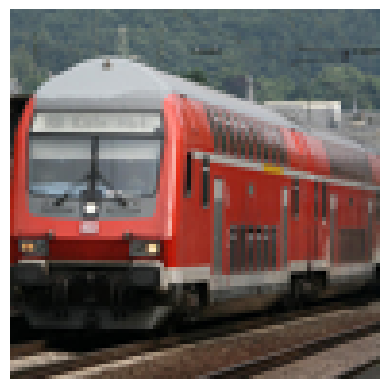

In [17]:
import matplotlib.pyplot as plt

# Access one batch of data from the DataLoader
for batch_idx, (data, _) in enumerate(unlabeled_loader):
    # Select the first image from the batch
    image = data[0]  # Assuming batch size is greater than 0
    # Convert the tensor to a numpy array and transpose it to the correct shape
    image_np = image.permute(1, 2, 0).numpy()
    # Denormalize the image (reverse normalization)
    image_np = 0.5 * image_np + 0.5
    # Display the image
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()
    break  # Break the loop after displaying one image


In [9]:
# Data loading
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(96, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Data loading with a subset of 1000 images
subset_size = 1000
train_size = int(0.8 * subset_size)
test_size = subset_size - train_size

train_dataset = datasets.STL10(root='data', split='train', download=True, transform=transform, target_transform=None)
test_dataset = datasets.STL10(root='data', split='test', download=True, transform=transform, target_transform=None)

# Create a subset of 1000 images
train_dataset.data = train_dataset.data[:subset_size]
train_dataset.targets = train_dataset.targets[:subset_size]

# Split the subset into training and testing sets
train_subset, test_subset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

# Data loaders for the subset
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False)


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting data/stl10_binary.tar.gz to data
Files already downloaded and verified


AttributeError: 'STL10' object has no attribute 'targets'

In [ ]:
# Training
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, criterion)
    evaluate(model, device, test_loader)
